## Pima Indians Diabetes Modeling
In the [previous notebook](https://www.kaggle.com/michaelchen1116/pima-indians-diabetes-eda): 

* We conducted exploratory data analysis on the `diabetes` dataset through process of **univariate analysis**, **bivariate analysis**, **missingness analysis**. 
* We identified zero entries as missing values in different columns and imputed those values using the existing data from those columms. 
* We selected columns that best explain the target variables and have low residuals relative to their counterpart (either original or bins that we created by cutting orginal columns).

This notebook contains the modeling step for the diabetes analysis. It presents the process of preprocessing, creating models, and comparing models using different evaluation metrics.

In [1]:
# data analysis, wrangling and preprocessing
import numpy as np
import pandas as pd
import random

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical modeling
import statsmodels.api as sm

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix 

### Loading Data
We start by loading the dataset from the previous anaysis into Pandas DataFrame.

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Here is a brief description of each column:
* `Pregnancies`: number of times pregnant
* `Glucose`: blood plasma glucose concentration a 2 hours in an oral glucose tolerance test
* `BloodPressure` : Diastolic blood pressure with a unit of  mm Hg
* `SkinThickness` : triceps skin fold thickness with a unit of mm
* `Insulin` : 2-Hour serum insulin with a unit of mu U/ml
* `BMI` : body mass index, which is calculated by weight in kg/(height in m)^2
* `DiabetesPedigreeFunction` : a synthesis of the diabetes mellitus history in relatives 
and the genetic relationship of those relatives to the subject
* `Age` : age of the patient in years
* `Outcome` : whether the patient has diabetes or not, which is our target variable that we are trying 
to predict

### Modeling approach
We plan to use **logistic regression**, **random forest**, and **gradient boosting** to model whether a given patient in the dataset is classified as having diabetes or not. We also plan to go through the process of hyperparameter tuning for each model using GridSearch to obtain the best result before we compare the results from different models using our evaluation metrics.

#### Preprocessing for modeling
We will go through the process as we did in the diabetes_EDA notebook for the completeness of the analysis. Here are several things we have to do to reach the resulting dataset from the diabetes_EDA notebook:
* Replace zeros by imputing existing values in that column randomly. 
* Next, we will cut some columns we selected in the previous notebook into bins since the original columns has either larger residual or lower R-square.

We identify zeros in `BloodPressure`, `Insulin`, and `SkinThickness` as missing values. As a result, we decided to handle them by imputing existing values in that column randomly. 

In [3]:
random.seed(0)
diabetes['BloodPressure']=diabetes['BloodPressure'].replace(0, random.choice(diabetes[diabetes.BloodPressure != 0 ]["BloodPressure"]))
diabetes['SkinThickness']=diabetes['SkinThickness'].replace(0, random.choice(diabetes[diabetes.SkinThickness != 0 ]["SkinThickness"]))
diabetes['Insulin']=diabetes['Insulin'].replace(0, random.choice(diabetes[diabetes.SkinThickness != 0 ]["Insulin"]))

We will cut these columns into bins since the original columns has either larger residual or lower R-square:
* `Insulin`
* `BMI`
* `DiabetesPedigreeFunction`

In [9]:
diabetes['Insulin_group'] = pd.cut(diabetes['Insulin'], bins = 3, labels=False)
diabetes['BMI_group'] = pd.cut(diabetes['BMI'], bins = 5, labels=False)
diabetes['pedigree_group'] = pd.cut(diabetes['DiabetesPedigreeFunction'], bins = 3, labels=False)

In [10]:
diabetes = diabetes[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin_group', 'BMI_group', 'pedigree_group', 'Outcome']]

We want to use the heatmap to see if there is any features that is highly-correlated to other features. If there is such feature, we have to drop them since they provide redundent information for our model.

Text(0.5, 1.0, 'Heapmap of Selected Feautures')

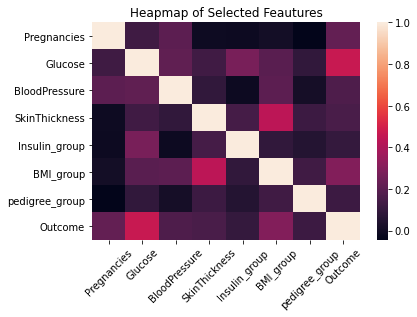

In [11]:
sns.heatmap(diabetes.corr())
plt.xticks(rotation=45)
plt.title("Heapmap of Selected Feautures")

There is not two columns that are significantly correlated with each other. We can proceed to modeling.

To avoid duplicate code, we decided to create `X` (independent variables) and `y` (dependent variable) in advance and conduct train_test_split for the purpose of getting more accurate results for the model evaulation process. 

In [12]:
X = diabetes.drop(columns=['Outcome'])
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### Logistic Regression
Logistic regression is perfect for binary classification problem like this one where we try to predict whether the patient has diabetes or not. It predicts the probability of each outcome and we can round it to 0 and 1. 

Here is a brief description about the parameters we are trying to tune:
* **Penalty**: the type of regularization between 'L1' and 'L2'. 'L1' is the Lasso regression, which adds an "squared-magnitude" of coefficient as penalty term in the loss function, while 'L2' is the Ridge regression, which adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
* **C**: the trade-off parameter of logistic regression that determine the strength of the regularization.

In [13]:
log_reg = LogisticRegression()

penalty = ['l1','l2']
C = np.linspace(0, 5, 10)
hyperparameters = dict(C=C, penalty=penalty)
# Create Grid Search using 5-fold cross validation
clf = GridSearchCV(log_reg, hyperparameters, cv = 5, verbose=0)
best_logic_model = clf.fit(X_train, y_train)

In [14]:
print('Best Penalty:', best_logic_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_logic_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.6666666666666667


We want to plot the different weights for the coefficients in the logistic regression model. And see how they relate to each other.

[[-1.3250252   0.14067183  0.03398157 -0.01819553 -0.00425175 -0.55446093
   1.11241128  0.58944403]]
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, 'pedigree_group'),
  Text(0.0, 0, 'Pregnancies'),
  Text(1.0, 0, 'Glucose'),
  Text(2.0, 0, 'BloodPressure'),
  Text(3.0, 0, 'SkinThickness'),
  Text(4.0, 0, 'Insulin_group'),
  Text(5.0, 0, 'BMI_group'),
  Text(6.0, 0, 'pedigree_group'),
  Text(7.0, 0, '')])

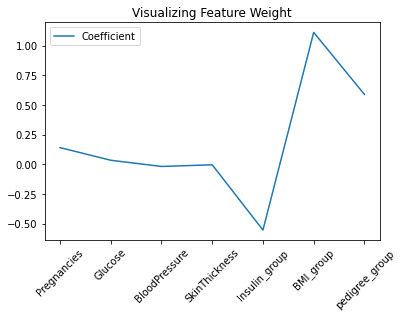

In [33]:
log_reg = LogisticRegression(penalty='l2', C=1.112)
model = log_reg.fit(X_train, y_train)
coef = model.coef_
print(coef)
coef_table = pd.DataFrame(coef.flatten(), index=X_train.columns, columns=['Coefficient'])
coef_table.iloc[1:,:].plot()
plt.title("Visualizing Feature Weight")
plt.xticks(rotation=45)

According to the line chart above, `BMI_group` has the most positive weight and `Insulin_group` has the most negative weight. This means those two features play a larger role in deciding the outcome of the logistic regression model.

To avoid redundent code, we created a function called `model_performance` that generates the number of true negatives, true positives, false negatives, and false positives. It has two parameters: `name` (the name of the model) and `prediction` (the prediction made by the given model). It creates a dictionary with the metrics we need to build a table later on to compare different models.

In [16]:
new_dict = {}
def model_performance(name, prediction):
    TN = confusion_matrix(y_test, prediction)[1,1]
    TP = confusion_matrix(y_test, prediction)[0,0]
    FN = confusion_matrix(y_test, prediction)[1,0]
    FP = confusion_matrix(y_test, prediction)[0,1]
    new_dict[name] = [TN, TP, FN, FP]
    return new_dict

We use the function that we just created to get metrics we need.

In [17]:
# performing predictions on the test datdaset 
yhat = best_logic_model.predict(X_test) 
prediction = list(map(round, yhat))
# getting model performance data for model evalation and comparison 
model_performance('Logistic', prediction)

{'Logistic': [42, 152, 42, 18]}

#### Random Forest
Random forest is a collection of decision trees and each tree is indepedent from others. The final call depends on the majority of the decision. 

Here is a brief description about the parameters we are trying to tune:
* **n_estimators**: number of trees in the forest
* **max_depth**: the depth of each tree in the forest
* **min_samples_split**: the minimum number of samples required to split an internal node

In [18]:
rf = RandomForestClassifier()

n_estimators = [1,2,4,8,16,32,64]
max_depth = np.linspace(1, 10, 10, endpoint=True)
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
# Create Grid Search using 3-fold cross validation
clf = GridSearchCV(rf, hyperparameters, cv = 3, verbose=0)
best_rf_model = clf.fit(X_train, y_train)

In [19]:
print('Best n_estimator:', best_rf_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_rf_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_rf_model.best_estimator_.get_params()['min_samples_split'])

Best n_estimator: 2
Best max_depth: 8.0
Best min_samples_split: 0.6


We want to see what are some features that play an importent part in deciding how to classify patients in this dataset into two distinct groups. 

No handles with labels found to put in legend.


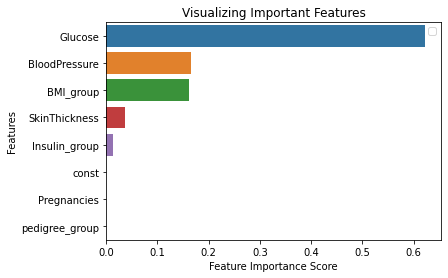

In [20]:
rf = RandomForestClassifier(n_estimators=2, max_depth=5, min_samples_split=0.2)
rf_model = rf.fit(X_train, y_train)
feature_imp = pd.Series(rf_model.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()

As we can see in the chart above, `Glucose` plays a significant role comparing with other features in deciding where to split the tree into different branches followed by `Pregnancies` and `BMI_group`. This makes sense because according to https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes diabetes normally occurs glucose, also called blood suger, is too high. Also, `BMI_group` and `Pregnancies` both reflect the weight of a patient, which is a crucial factor when determining whether a patient has diabetes or not.

It is surprising to us that Insulin doesn't play much a role here because it helps glucose from food get into your cells to be used for energy. The reason might be that we cut the original `Insulin` column into three evenly distributed bins instead of cutting them into bins according to medical ranges that define different levels of insulin.

Performing predictions on the test datdaset and using the function we created earlier to get model performance data for model evalation and comparison.

In [21]:
yhat = best_rf_model.predict(X_test) 
prediction = list(map(round, yhat)) 
model_performance('Random Forest', prediction)

{'Logistic': [42, 152, 42, 18], 'Random Forest': [25, 161, 59, 9]}

#### Gradient Boost Model
Gradient boosting relies on the intuition that the best possible next model, when combined with previous model, minimizes the overall prediction error.

Here is a brief description about the parameters we are trying to tune:
* **learning_rate**: the step size of optimization algorithm moving towards the objective
* **n_estimators**: number of trees in the forest
* **max_depth**: the depth of each tree in the forest
* **min_samples_split**: the minimum number of samples required to split an internal node

In [22]:
gb = GradientBoostingClassifier()

learning_rate = [1, 0.5, 0.25, 0.1]
n_estimators = [1,2,4,8,16,32,64]
max_depth = np.linspace(1, 5, 5, endpoint=True)
min_samples_split = np.linspace(0.1, 0.5, 5, endpoint=True)
hyperparameters = dict(learning_rate=learning_rate,n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
# Create Grid Search using 3-fold cross validation
clf = GridSearchCV(gb, hyperparameters, cv = 3, verbose=0)
best_gb_model = clf.fit(X_train, y_train)

In [23]:
print('Best learning_rate:', best_gb_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimator:', best_gb_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_gb_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_gb_model.best_estimator_.get_params()['min_samples_split'])

Best learning_rate: 0.5
Best n_estimator: 4
Best max_depth: 5.0
Best min_samples_split: 0.4


Performing predictions on the test datdaset and using the function we created earlier to get model performance data for model evalation and comparison.

In [24]:
yhat = best_gb_model.predict(X_test) 
prediction = list(map(round, yhat))
model_performance('Gradient Boosting', prediction)

{'Logistic': [42, 152, 42, 18],
 'Random Forest': [25, 161, 59, 9],
 'Gradient Boosting': [41, 147, 43, 23]}

#### Model performance comparison
Since this is a classification problem, we decided to use corresponding metrics to compare the model performance (listed as follow).
* **accuracy**: the proportion of predictions that are correct
* **sensitivity** (true positive rate): the proportion of true observations that are correctly predicted by the model as being true.
* **specificity** (true negative rate): the proportion of false observations that are correctly predicted by the model as being false.

To avoid repetitive code, we decided to creat a fucntion that calculate those different metrics that we just mentioned. 

In [25]:
def evaluation_metric(aDict):
    for name in aDict:
        TN = aDict[name][0]
        TP = aDict[name][1]
        FN = aDict[name][2]
        FP = aDict[name][3]
        accuracy = np.round((TN+TP)/ (TN+TP+FN+FP), 4)
        # sensitivity is calculated by the true positives over the sum of the true positives and false negatives
        sensitivity = np.round((TP)/ (TP+FN), 4)
        # specificity is calculated by the true negatives over the sum of the true negatives and the false positives
        specificity = np.round((TN)/ (TN+FP), 4)
        aDict[name].append(accuracy)
        aDict[name].append(sensitivity)
        aDict[name].append(specificity)
    return aDict

##### Create a table using the dictionary
The table includes performance data and evaluation metrics for each model.
* First, we count the number of test cases in each model
* Then, we want to transform the numbers in the confusion matrix into percentages.

In [26]:
# count the sum of test cases
sum_list = []
for aList in new_dict.values():
    aSum = 0
    for i in np.arange(4):
        aSum += aList[i]
    sum_list.append(aSum)
sum_list

[254, 254, 254]

In [27]:
for aList in new_dict.values():
    for j in np.arange(4):
        aList[j] = np.round(aList[j]/254, 3)

In [29]:
model_comparison = pd.DataFrame.from_dict(evaluation_metric(new_dict))
model_comparison = model_comparison.rename(index={0: "True Negative", 1: "True Positive", 2: "False Negative",3:'False Positive',
    4:'Accuracy',5:'Sensitivity',6:'Specificity'})
model_comparison

,Logistic,Random Forest,Gradient Boosting
True Negative,0.1650,0.0980,0.1610
True Positive,0.5980,0.6340,0.5790
False Negative,0.1650,0.2320,0.1690
False Positive,0.0710,0.0350,0.0910
Accuracy,0.7638,0.7327,0.7400
Sensitivity,0.7837,0.7321,0.7741
Specificity,0.6992,0.7368,0.6389


According to the table above, we can see that logistic regression seems to have the most accuracy in terms of predicting whether a patient in this dataset is classified as having diabetes or not. There is not much of a difference in model performance after the process of parameters tuning.

**Logistic Regression** algorithm has the highest true positive rate. This means that **Logistic Regression** useful in correctly predicting whether a patient should be classified as having diabetes.

**Logistic Regression** has the highest sensitivity. This means that Logistic Regression correctly generates a positive result for people who have diabetes more often than other models. Also, we have to note that a model with highly sensitive will flag almost everyone who has the disease and not generate many false-negative results. In this case, around 78% does not raise this red flag of being too high. 

**Logistic Regression** has the highest specificity. This means that Logistic Regression correctly generates a negative result for people who don't have diabetes. Similar to sensitivity, a high specificity will raise a red flag because it means model will classify everyone in the dataset as not having diabetes. In out Logistic Regression model, around 70% of specificity does not raise this red flag. 

Normally, we will choose the model that correctly identifying patients without diabetes was more important than correctly identifying patients with diabetes. Ane we will choose the model that correctly identifying patients with diabetes was more important than correctly identifying patients without diabetes. In this case, since **Logistic Regression** has the highest sensitivity and specificity at the same time. There is no doubt that it is our best model when we try to predict whether patients in this dataset have diabetes or not.

##### Functions that help us generate the ROC-AUC curve 
* `no_skill_prediction` generates a plot with a line that shows when the true positive equals the false positive rate.
* `graph_roc_auc` generates ROC-AUC curve for a given model

In [30]:
def no_skill_prediction():
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

def graph_roc_auc(model, name):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    # calculate score
    lr_auc = roc_auc_score(y_test, lr_probs)
    # print score
    print(name + ': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()

##### Produce the ROC AUC curves for all three models on the same graph
We generate ROC AUC curves for all three models on the same graph using the function we created earlier.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.833
Random Forest: ROC AUC=0.690
Gradient Boosting: ROC AUC=0.803


Text(0.5, 1.0, 'ROC AUC comparison')

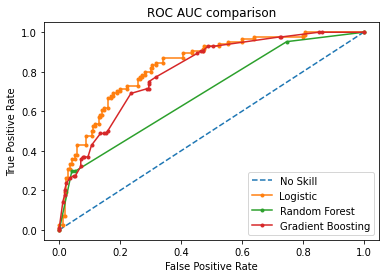

In [31]:
no_skill_prediction()
model = [best_logic_model, best_rf_model, best_gb_model]
name = ['Logistic','Random Forest','Gradient Boosting']
for i in range(len(model)):
    graph_roc_auc(model[i], name[i])
plt.title('ROC AUC comparison')

As shown in the ROC AUC curve above, the y-axis is the true positive rate (sensitivity), while the x-axis is the false positive rate (1- specificity). The true positive rate tells us the proportion of patients in this dataset that identified as having diabetes were correctly classified. The false positive rate tells us the proportion of patients in this dataset that identified as not having diabetes were correctly classified and are false positive. 

The line for each model as shown in orange, green and red illustrates the trade-off between we correctly classified all of the patients in this dataset that have diabetes and incorrectly classfied all of the patients in this dataset that don't have diabetes.

Area under the curve (AUC) makes it easier to compare one ROC curve to another. They were shown above the graph. The graph and the AUC confirm that we should choose logistic regression. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd4a356b-76ac-4ad6-9eb0-790688a80ec2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>